In [1]:
import os
import pandas as pd
import git
import matplotlib.pyplot as plt
import folderstats
import numpy as np
import math

folder = "../../data/format-corpus"
relative_path = '../../data/format-corpus'
repo = git.Git(folder)

N_rows = 1560
individual_operations = 2070
invididual_writes = 1560
p=0.005
p_meta = 0.8

In [2]:
def expected_operations(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    number_of_positive_pools = (1 - np.power((1-p),k)) * number_of_pools
    return np.ceil(number_of_pools + number_of_positive_pools*k)

def expected_writes(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    return number_of_pools

def expected_scrubbing(N,k,p):
    if(k==0.0):
        k=N
    number_of_pools = np.ceil(N/k)
    number_of_positive_pools = (1 - np.power((1-p),k))* number_of_pools
    return np.ceil(number_of_positive_pools*k)

def optimal_pool_size(N,p):
    if(p<=0.0):
        return N
    return np.ceil(1.24*np.power(p,-0.466))

# poc_ropsten.ipynb
gasAmount = 50870

In [3]:
p=0.005
p_meta = 0.8

In [4]:
df = folderstats.folderstats(folder, ignore_hidden=True,hash_name="sha256")
df = df[df.folder==False]
print(df.shape[0])
df["p"]=p
metadata = df.copy()
metadata["p"]=p_meta
metadata["name"]=metadata["name"]+".meta"
metadata["extension"]= "metadata"
df = pd.concat([df,metadata],ignore_index=True)
df["extension"]=df["extension"].fillna("None")
df["extension"].value_counts()

1560


metadata    1560
xml          986
pdf          106
md            74
mov           61
            ... 
WK3            1
indd           1
wb3            1
wb2            1
xhtml          1
Name: extension, Length: 92, dtype: int64

In [5]:
s1 = df["extension"].value_counts().rename("N")
s2 = df.groupby(["extension"])["p"].mean()
df_ = pd.concat([s1, s2], axis=1)
df_.head()

,N,p
metadata,1560,0.800
xml,986,0.005
pdf,106,0.005
md,74,0.005
mov,61,0.005


In [6]:
# calculate efficiency with dependent metadata
def efficiency(p,p_meta):
    df = folderstats.folderstats(folder, ignore_hidden=True,hash_name="sha256")
    df = df[df.folder==False]
    df["extension"]=df["extension"].fillna("None")
    df["p"]=p
    metadata = df.copy()
    metadata["p"]=p_meta
    metadata["name"]=metadata["name"]+".meta"
    metadata["extension"]= "metadata"
    df = pd.concat([df,metadata],ignore_index=True)
    positives = df.shape[0]*p
    positives_meta = metadata.shape[0]*p_meta
    positives = positives + positives_meta

    s1 = df["extension"].value_counts().rename("N")
    s2 = df.groupby(["extension"])["p"].mean()
    df_ = pd.concat([s1, s2], axis=1)
    df_["k"] = df_.apply(lambda row: optimal_pool_size(row.N,row.p),axis=1)
    df_["O(S_cs)"] = df_.apply(lambda row:  expected_operations(row.N,row.k,row.p),axis=1)
    df_["W(S_cs)"] = df_.apply(lambda row:  expected_writes(row.N,row.k,row.p),axis=1)


    efficiency_cs = individual_operations/df_["O(S_cs)"].sum()
    cost_cs = invididual_writes/df_["W(S_cs)"].sum()

    return[efficiency_cs,cost_cs]

df_[:15]
df = pd.DataFrame({"p":np.linspace(0.001,0.05,40),"p_meta":np.linspace(0.99,0.8,40)})
df["E(S_cs)"] = df.apply(lambda row: efficiency(row.p,row.p_meta)[0],axis=1)
df["C(S_cs)"] = df.apply(lambda row: efficiency(row.p,row.p_meta)[1],axis=1)
df.iloc[::5,:]

,p,p_meta,E(S_cs),C(S_cs)
0,0.001000,0.990000,0.770376,1.718062
5,0.007282,0.965641,0.733262,1.609907
10,0.013564,0.941282,0.711829,1.553785
15,0.019846,0.916923,0.696970,1.498559
20,0.026128,0.892564,0.687251,1.466165
25,0.032410,0.868205,0.678022,1.466165
30,0.038692,0.843846,0.671206,1.420765
35,0.044974,0.819487,0.664526,1.420765


In [7]:
df_["positives"] = df_.apply(lambda row: row.N*row.p,axis=1)
N=df_["N"].sum()
p=df_["positives"].sum()/N
k=optimal_pool_size(N,p)
print(k)
print(expected_operations(N,1,p))
expected_writes(N,1,p)

2.0
4376.0


3120.0

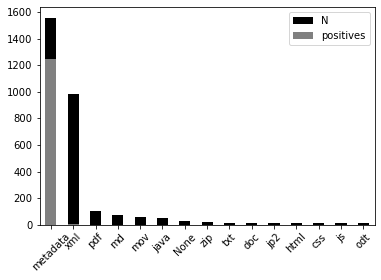

In [8]:
_, ax = plt.subplots()
df_["N"][:15].plot(kind='bar', ax=ax, color='black',rot=45)
df_["positives"][:15].plot(kind='bar', ax=ax, color='grey',rot=45)
ax.legend()

In [9]:
def eff(N,p,p_meta):
    return individual_operations/(expected_operations(N,optimal_pool_size(N,p_meta),p_meta)+expected_operations(N,optimal_pool_size(N,p),p))

def cost(N,p,p_meta):
    return invididual_writes/(expected_writes(N,optimal_pool_size(N,p_meta),p_meta)+expected_writes(N,optimal_pool_size(N,p),p))

df = pd.DataFrame({"p":np.linspace(0.001,0.05,40),"p_meta":np.linspace(0.99,0.8,40)})
df["E(S_h)"] = df.apply(lambda row: eff(1534,row.p,row["p_meta"]),axis=1)
df["C(S_h)"] = df.apply(lambda row: cost(1534,row.p,row["p_meta"]),axis=1)
df.iloc[::5,:]

,p,p_meta,E(S_h),C(S_h)
0,0.001000,0.990000,0.863219,1.914110
5,0.007282,0.965641,0.809226,1.762712
10,0.013564,0.941282,0.782017,1.693811
15,0.019846,0.916923,0.763556,1.626694
20,0.026128,0.892564,0.748644,1.580547
25,0.032410,0.868205,0.735869,1.580547
30,0.038692,0.843846,0.727848,1.524927
35,0.044974,0.819487,0.719000,1.524927


In [10]:
#df = pd.DataFrame({"p":np.linspace(0.001,0.05,40),"p_meta":np.linspace(0.99,0.8,40)})
df = pd.DataFrame({"p":np.linspace(0.001,0.05,3),"p_meta":np.linspace(0.99,0.8,3)})
df["E(S_cs)"] = df.apply(lambda row: efficiency(row.p,row.p_meta)[0],axis=1)
df["C(S_cs)"] = df.apply(lambda row: efficiency(row.p,row.p_meta)[1],axis=1)
df["E(S_h)"] = df.apply(lambda row: efficiency(row.p,row.p_meta)[2],axis=1)
df["C(S_h)"] = df.apply(lambda row: efficiency(row.p,row.p_meta)[3],axis=1)
df[:15]

IndexError: list index out of range

In [ ]:
df

,p,p_meta,E(S_cs),C(S_cs),E(S_h),C(S_h)
0,0.0010,0.990,0.770376,1.718062,0.532407,1.0
1,0.0255,0.895,0.687936,1.466165,0.542737,1.0
2,0.0500,0.800,0.659026,1.420765,0.553920,1.0
